### Load in initial packages

In [1]:
import pandas as pd
import oscn
import nltk
from bs4 import BeautifulSoup
import re
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#Uncomment on initial run -- #nltk.download('punkt')
from tqdm import tqdm
from difflib import SequenceMatcher
import pickle

In [2]:
#!pip install sklearn-crfsuite
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

## Lookup Docket Functions

In [4]:
def lookUpDocket(docNum):
    splitNum = docNum.split('-')
    #print(splitNum)
    docType = splitNum[0]
    year = splitNum[1]
    county ='Tulsa'
    docNum = splitNum[2]
    #print("Split: ", docType, ' ', year, ' ', docNum)
    case=oscn.request.Case(type=docType, year=year,county=county,number=docNum)
    return case

#### Pulling out Judge, defendant lawyer & state rep from given text

Commented out all of the print functions, so the execution of the code below isn't so lengthy

In [5]:
def matchTagPatterns(string, pattern):
    match_list = []
    #print("Pattern is ",pattern)
    pattern = re.sub(r'[^\w\s]','',pattern)
    pattern = pattern.strip()
    #print("Stripped Pattern: ",pattern)
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
        
    return match_list, string

def mark_sentence(s, match_list):
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'
        
    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def clean(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = re.sub(r'[^\w\s]','',text)
    return text

def create_data(df):
    match_list = []
    for text, annotation in zip(df.text, df.annotation):
        #print("Text : ", text)
        #print("annotation : ", annotation)
        text = clean(text)
        #print("text cleaned")
        text_ = text 
        #print(text_)

        for i in annotation:
            a, text_ = matchTagPatterns(text, i[0])
            #print('a:',a)
            #print('i:',i)
            if a:
                match_list.append((a[0][0], a[0][1], i[1]))
    d = mark_sentence(text, match_list)
    return d

#### Creating tuples and tagging out the keywords we want to identify

This sets up the data into easier to use pairs of `(word, tag)`

In [6]:
def createTuples(i, value, column):
    values = value.split('\n')
    tuples = []
    for val in values:
        tuples.append(tuple((val,column)))
    #print("found tuples ",tuples," for ", value)
    return tuples
#Tuple reference
#https://stackoverflow.com/questions/31175223/append-a-tuple-to-a-list-whats-the-difference-between-two-ways/31175264
def getValues(i,column):
    value = training[column][i]
    tuples = []
    #print("Values ", value, " found ", pd.isnull(value), " is null for column ",column)
    if not(pd.isnull(value)):
        if ('\n' in value):
            tuples = createTuples(i, value, column)
        else:
            tuples.append(tuple([value,column]))
    #print("tuple created ", tuples)
    return tuples
def zipTuples(lst):
    lst_tuple = [x for x in zip(*[iter(lst)]*2)]
    #print(lst_tuple)
    return lst_tuple
def getAnnotations(i, columns):
    annotations = []
    for column in columns:
        tuples = getValues(i,column)
        #print("tuples created =", tuples, " tuples")
        annotations = np.append(annotations,[[tuples]]) 
        #print("annotations created =", annotations, " annotations")
    return zipTuples(annotations)
        
def getTags(case,i):
    #print("This is the ",i,"th case")
    columns = ['Judge','Defendant lawyer','State Rep']
    annotations = getAnnotations(i, columns)
    tags = [[case.text, annotations]]
    return tags

## Features, Tokens, and Label Lists

Features used by the CRF Model, but not the eventual LSTM Neural Network. 

In [7]:
def word2features(sent, i):
    word = sent[i][0]
    #postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        #postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        #postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [8]:
def tagsToSent(tags):
    sentList = []
    for i in range(len(tags)):
        #https://www.kite.com/python/answers/how-to-convert-a-dictionary-into-a-list-of-tuples-in-python
        #print(tags[i].items())
        dictItems = tags[i].items()
        sentList.append(list(dictItems))
    return sentList

## Running Dockets through Tagger 

### Pulling in the Training Data

* If you've got the pickled file `taggedNERSet`  and want to see setup for NN, then you can skip to the Word Mapping section
* If you've got the pickled files `X`,`y`,`X_val`,`y_val`, you can skip to the Bidirectional LSTM section where the Neural Network modelling starts

In [8]:
#Load in data
training = pd.read_csv('../../Data/judge_training_labels.csv')
training.head()

,Docket Number,Conviction,NER Training Paragraph,Judge,Defendant lawyer,State Rep,Sentencing,Link,Year
0,CF-2012-5905,Y,JUDGE DAWN MOODY: DEFENDANT PRESENT NOT IN CUS...,DAWN MOODY,SHEILA NAIFEH,JULIANNE BURTON,TWO (2) YEARS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
1,CF-2012-5896,Y,JUDGE JAMES CAPUTO: DEFENDANT PRESENT REPRESEN...,JAMES CAPUTO,DARRELL BOLTON,KALI STRAIN,TWO (2) YEARS DEPARTMENT OF CORRECTIONS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
2,CF-2012-5886,Y,JUDGE JAMES CAPUTO: DEFENDANT PRESENT IN CUSTO...,JAMES CAPUTO,ADAM HASELGREN,KALI STRAIN,THREE (3) YEARS IN DEPARTMENT OF CORRECTIONS,https://www.oscn.net/dockets/GetCaseInformatio...,2012
3,CF-2012-5591,N,JUDGE CLIFFORD SMITH: DEFENDANT PRESENT IN CUS...,CLIFFORD SMITH,CLAY IJAMS,SEAN HILL,STATE DISMISSES,https://www.oscn.net/dockets/GetCaseInformatio...,2012
4,CF-2012-5914,Y,\nJUDGE STEPHEN CLARK: DEFENDANT PRESENT NOT I...,STEPHEN CLARK,CARLOS WILLIAMS,ERIC LOGGIN,FIVE (5) YEAR DEFERRED SENTENCE\nFIVE (5) YEAR...,https://www.oscn.net/dockets/GetCaseInformatio...,2012


In [15]:
#Reviewing the one record to validate
#training.iloc[[n]]

Example of usage of the `lookUpDocket` function using the first row's Docket Number column

In [16]:
#Parse out the Docket number using the above function
#testNum = training['Docket Number'][0]
#case = lookUpDocket(testNum) #training['Docket Number'][0]
#case

Example of usage of the `word_tokenize`

In [17]:
#Return a tokenized copy of text
#tokenizedCase = word_tokenize(case.text)
#tokenizedCase

### Pulling out the Judge, Defendant Lawyer & State Rep from training set

In [18]:
allTags =[]
for i in training.index:
    case = lookUpDocket(training['Docket Number'][i])
    data = pd.DataFrame(getTags(case,i), columns=['text', 'annotation'])
    taggedSet = create_data(data)
    allTags.append(taggedSet)
#allTags[0]

#### Converting a dictionary into a list of tuples

`tagsToSent` takes the given tagged dictionary for each document and turns them into a list form. This `sentList` is now a list of lists that represent a single OSCN document's text: 

`[document1,document2...]`

Sentences are the normal way documents are broken up and tagged. We are treating each OSCN document as a 'sentence' to keep documents together and for ease of assigning the entities to a case number. Each of these documents are made up of tagged word lists in tuple form:

`[('OSCN','O'),...,('JANE', 'B-State Rep'), ('DOE', 'I-State Rep'),...]`

In [19]:
sentList = tagsToSent(allTags)
#sentList[0]

In [20]:
# Pickle tagged data for later runs without invoking the OSCN scraper
file_name = f'taggedNERSet'
f = open(file_name, 'wb')
pickle.dump(sentList, f)
f.close()

In [9]:
#Use pickled data from above tagging
file_name = f'taggedNERSet'
sentList2 = pickle.load(open(file_name, 'rb'))
#testing load to new list to ensure we actually saved and reloaded
#sentList2[0]

## Running against a CRF Model

Just for mechanics sake seeing if we've gotten the data into a state that it can be manipulated by a model (that's why test and train are the same set) Run the above cell that loads processed training data into sentList2

In [10]:
from itertools import chain
import matplotlib.pyplot as plt

import nltk
import sklearn
import scipy.stats
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import cross_val_score
# from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [11]:
%%time
from sklearn.model_selection import train_test_split

X = [sent2features(s) for s in sentList2]
y = [sent2labels(s) for s in sentList2]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

Wall time: 227 ms


In [12]:
labels = ['B-Judge',
 'B-State Rep',
 'I-State Rep',
 'B-Defendant lawyer',
 'I-Defendant lawyer',
 'I-Judge']

In [13]:
%%time
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        random_state = 123)
rs.fit(X_train, y_train) 



Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


Wall time: 2min 12s
Wall time: 2min 12s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A91237E3A0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A91237E640>},
                   random_state=123, verbose=1)

best params: {'c1': 0.08306892029976798, 'c2': 0.059459058557582024}
best CV score: 0.9926190440948653
model size: 0.20M
Dark blue => 0.9917, dark red => 0.9926


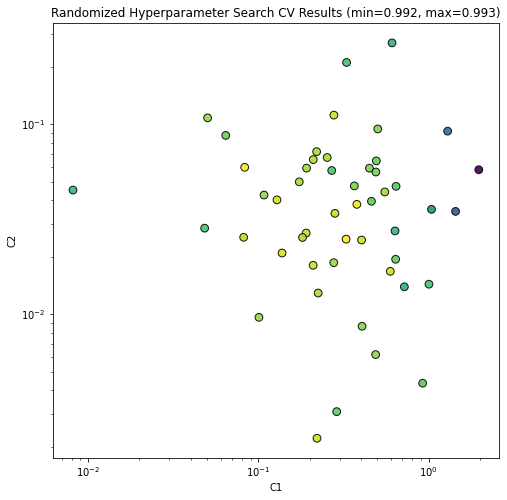

In [14]:
# standard metric outputs
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

# extracting parameters from the grid search for plotting
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = rs.cv_results_['mean_test_score'].tolist()

# plotting
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [15]:
rs.best_params_

{'c1': 0.08306892029976798, 'c2': 0.059459058557582024}

In [16]:
#rs.best_params_list(my_dict.keys())[0]

### Applying optimal hyperparamters to model

In [17]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1= 0.08306892029976798,
    c2=0.059459058557582024,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 6.46 s


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.08306892029976798,
    c2=0.059459058557582024, keep_tempfiles=None, max_iterations=100)

In [60]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-Judge',
 'I-Judge',
 'B-Defendant lawyer',
 'I-Defendant lawyer',
 'B-State Rep',
 'I-State Rep']

In [18]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.5365921748370869

In [19]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                    precision    recall  f1-score   support

B-Defendant lawyer      0.783     0.439     0.562        41
I-Defendant lawyer      0.759     0.500     0.603        44
           B-Judge      0.789     0.395     0.526        38
           I-Judge      0.727     0.372     0.492        43
       B-State Rep      0.762     0.390     0.516        41
       I-State Rep      0.762     0.390     0.516        41

         micro avg      0.763     0.415     0.538       248
         macro avg      0.764     0.414     0.536       248
      weighted avg      0.763     0.415     0.537       248



# Word Mapping

Load in the previous run pickle data which includes the 3 key columns to train the model on in the right format 

In [77]:
#Use pickled data from above tagging
file_name = f'taggedNERSet'
sentList2 = pickle.load(open(file_name, 'rb'))

In [78]:
#sentList2[55]

In [79]:
#sentList
X_train = [sent2tokens(s) for s in sentList2]
y_train = [sent2labels(s) for s in sentList2]

#test is same as train just for functionality testing
X_test = [sent2tokens(s) for s in sentList2]
y_test = [sent2labels(s) for s in sentList2]

In [80]:
#X_train[1]

In [81]:
for i in zip(X_train[1],y_train[1]):
    print(i)

('OSCN', 'O')
('Case', 'O')
('Details', 'O')
('Skip', 'O')
('to', 'O')
('Main', 'O')
('Content', 'O')
('Accessibility', 'O')
('Statement', 'O')
('Help', 'O')
('Contact', 'O')
('Us', 'O')
('epayments', 'O')
('Careers', 'O')
('toggle', 'O')
('navigation', 'O')
('Home', 'O')
('Courts', 'O')
('Decisions', 'O')
('Programs', 'O')
('News', 'O')
('Legal', 'O')
('Research', 'O')
('Court', 'O')
('Records', 'O')
('Quick', 'O')
('Links', 'O')
('The', 'O')
('information', 'O')
('on', 'O')
('this', 'O')
('page', 'O')
('is', 'O')
('NOT', 'O')
('an', 'O')
('official', 'O')
('record', 'O')
('Do', 'O')
('not', 'O')
('rely', 'O')
('the', 'O')
('correctness', 'O')
('or', 'O')
('completeness', 'O')
('of', 'O')
('Verify', 'O')
('all', 'O')
('with', 'O')
('keeper', 'O')
('contained', 'O')
('in', 'O')
('report', 'O')
('provided', 'O')
('compliance', 'O')
('Oklahoma', 'O')
('Open', 'O')
('Act', 'O')
('51', 'O')
('OS', 'O')
('24A1', 'O')
('Use', 'O')
('governed', 'O')
('by', 'O')
('act', 'O')
('as', 'O')
('well

In [84]:
from collections import Counter
def trainingSetToWordMap(X_train):
    words = []
    for entry in X_train:
        for word in entry:
            words.append(word)
    #Unique words counted in the dockets, then mapping the words to a number (which will then be used in the NN)
    wc = Counter(words)
    print(len(wc))
    word_map = {}
    for i,(k,v) in enumerate(wc.most_common()):
        word_map[k] = i+2 #starting sequence after unknowns
    word_map['<pad>']=0 #padding values
    word_map['<unk>']=1 #unknown values
    return word_map

In [85]:
word_map= trainingSetToWordMap(X_train)

15841


In [18]:
word_map

{'OSCN': 2,
 'Case': 3,
 'Details': 4,
 'Skip': 5,
 'to': 6,
 'Main': 7,
 'Content': 8,
 'Accessibility': 9,
 'Statement': 10,
 'Help': 11,
 'Contact': 12,
 'Us': 13,
 'epayments': 14,
 'Careers': 15,
 'toggle': 16,
 'navigation': 17,
 'Home': 18,
 'Courts': 19,
 'Decisions': 20,
 'Programs': 21,
 'News': 22,
 'Legal': 23,
 'Research': 24,
 'Court': 25,
 'Records': 26,
 'Quick': 27,
 'Links': 28,
 'The': 29,
 'information': 30,
 'on': 31,
 'this': 32,
 'page': 33,
 'is': 34,
 'NOT': 35,
 'an': 36,
 'official': 37,
 'record': 38,
 'Do': 39,
 'not': 40,
 'rely': 41,
 'the': 42,
 'correctness': 43,
 'or': 44,
 'completeness': 45,
 'of': 46,
 'Verify': 47,
 'all': 48,
 'with': 49,
 'keeper': 50,
 'contained': 51,
 'in': 52,
 'report': 53,
 'provided': 54,
 'compliance': 55,
 'Oklahoma': 56,
 'Open': 57,
 'Act': 58,
 '51': 59,
 'OS': 60,
 '24A1': 61,
 'Use': 62,
 'governed': 63,
 'by': 64,
 'act': 65,
 'as': 66,
 'well': 67,
 'other': 68,
 'applicable': 69,
 'state': 70,
 'and': 71,
 'feder

In [86]:
%store word_map

Stored 'word_map' (dict)


In [19]:
#Pulling out the tag map that we want to focus on training the data on ( 0 = unknown/pad )
## Does the label/ordering of this map matter?
tags = []
for entry in y_train:
    for tag in entry:
        tags.append(tag)
tags = list(set(tags))

tag_map = {}
for i,v in enumerate(tags):
    tag_map[v] = i+1
    tag_map[0] = 0
    
tag_map

{'I-Defendant lawyer': 1,
 0: 0,
 'B-State Rep': 2,
 'B-Defendant lawyer': 3,
 'I-State Rep': 4,
 'I-Judge': 5,
 'O': 6,
 'B-Judge': 7}

In [20]:
%store tag_map

Stored 'tag_map' (dict)


In [56]:
tag_map

{'I-Defendant lawyer': 1,
 0: 0,
 'B-State Rep': 2,
 'B-Defendant lawyer': 3,
 'I-State Rep': 4,
 'I-Judge': 5,
 'O': 6,
 'B-Judge': 7}

In [21]:
X=[]
y=[]
for sent in X_train:
    X.append([word_map[i] for i in sent])
for seq in y_train:
    y.append([tag_map[i] for i in seq])
X_val = []
y_val = []

#TO DO: Actual Train Test Split
for sent in X_test:
    X_val.append([word_map[i] if i in word_map.keys() else 1 for i in sent])
for seq in y_test:
    y_val.append([tag_map[i] for i in seq])

In [22]:
#This is calling just the index within the wordmap, because NN can only handle numbers
#X[0]

In [23]:
print(max([len(i) for i in X]))

1243


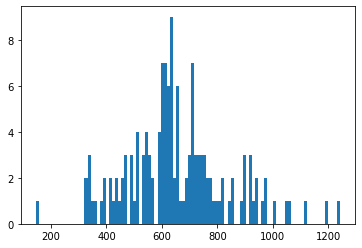

In [24]:
#Looking at the distribution of data
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([len(i) for i in X],bins=100)
plt.show()

In [25]:
#In order to achieve a confidence interval, select the quartile for the model to train on
import numpy as np
print(np.quantile([len(i) for i in X],0.75))
print(np.quantile([len(i) for i in X],0.95))
print(np.quantile([len(i) for i in X],0.99))

744.75
969.4499999999998
1162.089999999999


In [26]:
max_len = 1000
from tensorflow.keras.preprocessing import sequence

#Preparing the data for Neural Net (padding the data to be all the same length)
X = sequence.pad_sequences(X, maxlen=max_len)
y = sequence.pad_sequences(y, maxlen=max_len)
X_val = sequence.pad_sequences(X_val, maxlen=max_len)
y_val = sequence.pad_sequences(y_val, maxlen=max_len)

## Storing final processed datasets

In [27]:
%store X
%store y
%store X_val
%store y_val

Stored 'X' (ndarray)
Stored 'y' (ndarray)
Stored 'X_val' (ndarray)
Stored 'y_val' (ndarray)


In [28]:
# X
f = open('X', 'wb')
pickle.dump(X, f)
f.close()
# y
f = open('y', 'wb')
pickle.dump(y, f)
f.close()
# X_val
f = open('X_val', 'wb')
pickle.dump(X_val, f)
f.close()
# y_val
f = open('y_val', 'wb')
pickle.dump(y_val, f)
f.close()

In [45]:
#example of a padded sentence (with leading 0s)
#X[0]

# Bidirectional LSTM
TODO: word_map is also required to run

In [97]:
#Unpickle our
# X
X = pickle.load(open('X', 'rb'))
# y
y = pickle.load(open('y', 'rb'))
#Since we are using 5 fold Cross Validation and have a small training set, this is currently just the training set
# X_val
X_val = pickle.load(open('X_val', 'rb'))
# y_val
y_val = pickle.load(open('y_val', 'rb'))

Test NN to ensure our data is setup properly

In [48]:
safety = EarlyStopping(monitor='val_loss', patience=1)
# create the model
word_vector_len = 100
model1 = Sequential()
model1.add(Embedding(len(word_map), word_vector_len, input_length=max_len))
model1.add(Bidirectional(LSTM(256, return_sequences=True)))
model1.add(Dropout(0.25))
model1.add(TimeDistributed(Dense(len(tag_map),activation='softmax')))

In [49]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### What does non-trainable parameters mean? is there a threshold we should expect to see in test set?

In [50]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         1582100   
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         731136    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 512)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 8)           4104      
Total params: 2,317,340
Trainable params: 2,317,340
Non-trainable params: 0
_________________________________________________________________


In [51]:
#Running the model
model1.fit(X,y, epochs=100, validation_data=(X_val,y_val), batch_size=20, callbacks = [safety])

Epoch 1/100
11/11 [==============================] - 32s 3s/step - loss: 1.8414 - accuracy: 0.6999 - val_loss: 0.7463 - val_accuracy: 0.9911
Epoch 2/100
11/11 [==============================] - 27s 2s/step - loss: 0.3542 - accuracy: 0.9757 - val_loss: 0.0962 - val_accuracy: 0.9872
Epoch 3/100
11/11 [==============================] - 30s 3s/step - loss: 0.0878 - accuracy: 0.9879 - val_loss: 0.0688 - val_accuracy: 0.9892
Epoch 4/100
11/11 [==============================] - 31s 3s/step - loss: 0.0651 - accuracy: 0.9908 - val_loss: 0.0584 - val_accuracy: 0.9920
Epoch 5/100
11/11 [==============================] - 31s 3s/step - loss: 0.0578 - accuracy: 0.9925 - val_loss: 0.0521 - val_accuracy: 0.9939
Epoch 6/100
11/11 [==============================] - 33s 3s/step - loss: 0.0516 - accuracy: 0.9934 - val_loss: 0.0489 - val_accuracy: 0.9930
Epoch 7/100
11/11 [==============================] - 30s 3s/step - loss: 0.0500 - accuracy: 0.9935 - val_loss: 0.0476 - val_accuracy: 0.9939
Epoch 8/100
1

In [52]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         1582100   
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         731136    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 512)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 8)           4104      
Total params: 2,317,340
Trainable params: 2,317,340
Non-trainable params: 0
_________________________________________________________________


In [53]:
fname = 'test_model.h5'

In [54]:
model1.save(fname)

In [55]:
from keras.models import load_model
model = load_model(fname)

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         1582100   
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         731136    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 512)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 8)           4104      
Total params: 2,317,340
Trainable params: 2,317,340
Non-trainable params: 0
_________________________________________________________________


model.summary()

# K=Fold Cross Validation with Keras
#https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

In [51]:
def kfolds_bidir(n,dropout,learning,n_epochs,pat ):
    # K-fold Cross Validation model evaluation
    fold_no = 1
    acc_per_fold =[]
    loss_per_fold=[]
    
    classificat_reports=[]
    
    safety = EarlyStopping(monitor='val_loss', patience=pat)

    kf = KFold(n_splits = n)
    for train, test in kf.split(X, y):

      # Define the model architecture
        model1 = Sequential()
        model1.add(Embedding(len(word_map), 300, input_length=max_len))
        model1.add(Bidirectional(LSTM(256, return_sequences=True)))
        model1.add(Dropout(dropout)) #play with this value 
        model1.add(TimeDistributed(Dense(len(tag_map),activation='softmax')))

        opt =Adam(learning_rate=learning)
        
      # Compile the model
        #change the learning rate
        model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


      # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

      # Fit data to model
        history = model1.fit(X,y, epochs=n_epochs, validation_data=(X_val,y_val), batch_size=20, 
                             callbacks = [safety]) #add weights param

      # Generate generalization metrics
        scores = model1.evaluate(X[test], y[test], verbose=0)
        
        #preds = model1.predict(X[test])
        #classificat_reports = classification_report(
        #    y[test].ravel(), np.argmax(preds,axis=2).ravel(), digits=3
        #)
        print(classificat_reports)
        print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

      # Increase fold number
        fold_no = fold_no + 1
    return (acc_per_fold, loss_per_fold,classificat_reports)

In [41]:
#word_vector_search = [100,200,300,400,500,600,700,800,900]
dropout_search = [0.25,0.10,0.35,0.5]
learning_search = [0.01,0.05,0.005,0.0005,0.075,0.025,0.03,]
full_acc_per_fold =[]
full_loss_per_fold=[]
full_classificat_reports = []
k = 5
for i in range(len(dropout_search)):
    avg_acc_per_fold =[]
    avg_loss_per_fold=[]
    classificat_reports = []
    for j in range(len(learning_search)):
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training fordropout {dropout_search[i]} and {learning_search[j]}...')
        results = kfolds_bidir(k,dropout_search[i],learning_search[j],40, 1) #40 epochs, 1 stop tolerance
        avg_acc_per_fold.append(sum(results[0])/k)
        avg_loss_per_fold.append(sum(results[1])/k)
        classificat_reports.append(results[2])
    full_acc_per_fold.append(avg_acc_per_fold)
    full_loss_per_fold.append(avg_loss_per_fold)
    full_classificat_reports.append(classificat_reports)


# create the model




------------------------------------------------------------------------
Training fordropout 0.25 and 0.01...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
11/11 [==============================] - 28s 2s/step - loss: 1.9759 - accuracy: 0.5588 - val_loss: 0.3216 - val_accuracy: 0.8252
Epoch 2/40
11/11 [==============================] - 24s 2s/step - loss: 0.2009 - accuracy: 0.9345 - val_loss: 0.0761 - val_accuracy: 0.9903
Epoch 3/40
11/11 [==============================] - 25s 2s/step - loss: 0.0694 - accuracy: 0.9905 - val_loss: 0.0457 - val_accuracy: 0.9920
Epoch 4/40
11/11 [==============================] - 25s 2s/step - loss: 0.0456 - accuracy: 0.9919 - val_loss: 0.0326 - val_accuracy: 0.9928
Epoch 5/40
11/11 [==============================] - 25s 2s/step - loss: 0.0325 - accuracy: 0.9928 - val_loss: 0.0248 - val_accuracy: 0.9940
Epoch 6/40
11/11 [==============================] - 25s 2s/step - loss: 0.0247 - accuracy: 0.

11/11 [==============================] - 28s 2s/step - loss: 1.5342 - accuracy: 0.5441 - val_loss: 0.1017 - val_accuracy: 0.9834
Epoch 2/40
11/11 [==============================] - 25s 2s/step - loss: 0.1017 - accuracy: 0.9860 - val_loss: 0.0729 - val_accuracy: 0.9920
Epoch 3/40
11/11 [==============================] - 25s 2s/step - loss: 0.0807 - accuracy: 0.9910 - val_loss: 0.0489 - val_accuracy: 0.9930
Epoch 4/40
11/11 [==============================] - 25s 2s/step - loss: 0.0724 - accuracy: 0.9894 - val_loss: 0.0905 - val_accuracy: 0.9796
[]
Score for fold 1: loss of 0.04943469539284706; accuracy of 99.39285516738892%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/40
11/11 [==============================] - 28s 2s/step - loss: 2.1741 - accuracy: 0.5786 - val_loss: 0.0780 - val_accuracy: 0.9911
Epoch 2/40
11/11 [==============================] - 25s 2s/step - loss: 0.0761 - accuracy: 0.9914 - val_loss: 0.0654 - val_accuracy: 

11/11 [==============================] - 25s 2s/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.0121 - val_accuracy: 0.9968
Epoch 13/40
11/11 [==============================] - 25s 2s/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.0107 - val_accuracy: 0.9971
Epoch 14/40
11/11 [==============================] - 25s 2s/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.0093 - val_accuracy: 0.9975
Epoch 15/40
11/11 [==============================] - 25s 2s/step - loss: 0.0091 - accuracy: 0.9977 - val_loss: 0.0078 - val_accuracy: 0.9983
Epoch 16/40
11/11 [==============================] - 25s 2s/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.0065 - val_accuracy: 0.9987
Epoch 17/40
11/11 [==============================] - 25s 2s/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0054 - val_accuracy: 0.9989
Epoch 18/40
11/11 [==============================] - 25s 2s/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0044 - val_accuracy: 0.9991
Epoch 19/40
11/11 [======

11/11 [==============================] - 25s 2s/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0174 - val_accuracy: 0.9945
Epoch 34/40
11/11 [==============================] - 25s 2s/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0173 - val_accuracy: 0.9945
Epoch 35/40
11/11 [==============================] - 25s 2s/step - loss: 0.0184 - accuracy: 0.9943 - val_loss: 0.0181 - val_accuracy: 0.9944
[]
Score for fold 5: loss of 0.01770816184580326; accuracy of 99.45714473724365%
------------------------------------------------------------------------
Training fordropout 0.25 and 0.075...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
11/11 [==============================] - 28s 2s/step - loss: 5.5843 - accuracy: 0.4615 - val_loss: 5.8776 - val_accuracy: 0.6353
Epoch 2/40
11/11 [==============================] - 25s 2s/step - loss: 5.9065 - accuracy: 0.6335 - val_loss: 5.8776 - val_accuracy: 0.6353
[]
Score for fold 1:

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
11/11 [==============================] - 28s 2s/step - loss: 4.1467 - accuracy: 0.3208 - val_loss: 0.3176 - val_accuracy: 0.9817
Epoch 2/40
11/11 [==============================] - 25s 2s/step - loss: 0.3075 - accuracy: 0.8984 - val_loss: 0.1276 - val_accuracy: 0.9865
Epoch 3/40
11/11 [==============================] - 25s 2s/step - loss: 0.1218 - accuracy: 0.9870 - val_loss: 0.0992 - val_accuracy: 0.9937
Epoch 4/40
11/11 [==============================] - 25s 2s/step - loss: 0.0994 - accuracy: 0.9936 - val_loss: 0.0979 - val_accuracy: 0.9939
Epoch 5/40
11/11 [==============================] - 25s 2s/step - loss: 0.0964 - accuracy: 0.9940 - val_loss: 0.0978 - val_accuracy: 0.9939
Epoch 6/40
11/11 [==============================] - 25s 2s/step - loss: 0.0958 - accuracy: 0.9940 - val_loss: 0.0977 - val_accuracy: 0.9939
Epoch 7/40
11/11 [==============================] - 25s 2s/step

Epoch 19/40
11/11 [==============================] - 25s 2s/step - loss: 0.0958 - accuracy: 0.9940 - val_loss: 0.0963 - val_accuracy: 0.9939
Epoch 20/40
11/11 [==============================] - 25s 2s/step - loss: 0.0959 - accuracy: 0.9940 - val_loss: 0.0961 - val_accuracy: 0.9940
Epoch 21/40
11/11 [==============================] - 26s 2s/step - loss: 0.0971 - accuracy: 0.9939 - val_loss: 0.0957 - val_accuracy: 0.9940
Epoch 22/40
11/11 [==============================] - 25s 2s/step - loss: 0.0962 - accuracy: 0.9938 - val_loss: 0.0953 - val_accuracy: 0.9940
Epoch 23/40
11/11 [==============================] - 25s 2s/step - loss: 0.0960 - accuracy: 0.9939 - val_loss: 0.0951 - val_accuracy: 0.9940
Epoch 24/40
11/11 [==============================] - 26s 2s/step - loss: 0.0970 - accuracy: 0.9938 - val_loss: 0.0949 - val_accuracy: 0.9940
Epoch 25/40
11/11 [==============================] - 26s 2s/step - loss: 0.0969 - accuracy: 0.9939 - val_loss: 0.0948 - val_accuracy: 0.9940
Epoch 26/40
1

11/11 [==============================] - 29s 2s/step - loss: 1.9001 - accuracy: 0.6251 - val_loss: 0.0478 - val_accuracy: 0.9940
Epoch 2/40
11/11 [==============================] - 25s 2s/step - loss: 0.0459 - accuracy: 0.9940 - val_loss: 0.0345 - val_accuracy: 0.9940
Epoch 3/40
11/11 [==============================] - 26s 2s/step - loss: 0.0332 - accuracy: 0.9939 - val_loss: 0.0253 - val_accuracy: 0.9939
Epoch 4/40
11/11 [==============================] - 25s 2s/step - loss: 0.0248 - accuracy: 0.9939 - val_loss: 0.0193 - val_accuracy: 0.9944
Epoch 5/40
11/11 [==============================] - 26s 2s/step - loss: 0.0180 - accuracy: 0.9945 - val_loss: 0.0154 - val_accuracy: 0.9952
Epoch 6/40
11/11 [==============================] - 25s 2s/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0156 - val_accuracy: 0.9950
[]
Score for fold 5: loss of 0.014619546011090279; accuracy of 99.55475926399231%
------------------------------------------------------------------------
Training fordrop

Epoch 22/40
11/11 [==============================] - 27s 2s/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 23/40
11/11 [==============================] - 27s 2s/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 24/40
11/11 [==============================] - 22s 2s/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 25/40
11/11 [==============================] - 22s 2s/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 26/40
11/11 [==============================] - 22s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9998
Epoch 27/40
11/11 [==============================] - 24s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 9.9056e-04 - val_accuracy: 0.9998
Epoch 28/40
11/11 [==============================] - 25s 2s/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 8.4109e-04 - val_accuracy: 0.9998
Epoch

Epoch 8/40
11/11 [==============================] - 22s 2s/step - loss: 0.0377 - accuracy: 0.9940 - val_loss: 0.0358 - val_accuracy: 0.9940
Epoch 9/40
11/11 [==============================] - 22s 2s/step - loss: 0.0357 - accuracy: 0.9939 - val_loss: 0.0344 - val_accuracy: 0.9940
Epoch 10/40
11/11 [==============================] - 22s 2s/step - loss: 0.0343 - accuracy: 0.9940 - val_loss: 0.0331 - val_accuracy: 0.9940
Epoch 11/40
11/11 [==============================] - 22s 2s/step - loss: 0.0328 - accuracy: 0.9940 - val_loss: 0.0323 - val_accuracy: 0.9940
Epoch 12/40
11/11 [==============================] - 22s 2s/step - loss: 0.0321 - accuracy: 0.9939 - val_loss: 0.0309 - val_accuracy: 0.9940
Epoch 13/40
11/11 [==============================] - 22s 2s/step - loss: 0.0312 - accuracy: 0.9939 - val_loss: 0.0297 - val_accuracy: 0.9940
Epoch 14/40
11/11 [==============================] - 22s 2s/step - loss: 0.0299 - accuracy: 0.9939 - val_loss: 0.0287 - val_accuracy: 0.9940
Epoch 15/40
11/

Epoch 29/40
11/11 [==============================] - 27s 2s/step - loss: 0.0233 - accuracy: 0.9940 - val_loss: 0.0228 - val_accuracy: 0.9940
Epoch 30/40
11/11 [==============================] - 27s 2s/step - loss: 0.0225 - accuracy: 0.9941 - val_loss: 0.0219 - val_accuracy: 0.9940
Epoch 31/40
11/11 [==============================] - 27s 2s/step - loss: 0.0218 - accuracy: 0.9940 - val_loss: 0.0211 - val_accuracy: 0.9941
Epoch 32/40
11/11 [==============================] - 27s 2s/step - loss: 0.0214 - accuracy: 0.9940 - val_loss: 0.0204 - val_accuracy: 0.9941
Epoch 33/40
11/11 [==============================] - 27s 3s/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0196 - val_accuracy: 0.9942
Epoch 34/40
11/11 [==============================] - 27s 2s/step - loss: 0.0195 - accuracy: 0.9942 - val_loss: 0.0189 - val_accuracy: 0.9943
Epoch 35/40
11/11 [==============================] - 28s 3s/step - loss: 0.0188 - accuracy: 0.9943 - val_loss: 0.0182 - val_accuracy: 0.9943
Epoch 36/40
1

11/11 [==============================] - 31s 3s/step - loss: 1.2270 - accuracy: 0.7141 - val_loss: 0.2617 - val_accuracy: 0.8986
Epoch 3/40
11/11 [==============================] - 28s 3s/step - loss: 0.2331 - accuracy: 0.9313 - val_loss: 0.1359 - val_accuracy: 0.9764
Epoch 4/40
11/11 [==============================] - 31s 3s/step - loss: 0.1338 - accuracy: 0.9761 - val_loss: 0.0985 - val_accuracy: 0.9822
Epoch 5/40
11/11 [==============================] - 27s 2s/step - loss: 0.0926 - accuracy: 0.9844 - val_loss: 0.0774 - val_accuracy: 0.9892
Epoch 6/40
11/11 [==============================] - 30s 3s/step - loss: 0.0807 - accuracy: 0.9893 - val_loss: 0.0698 - val_accuracy: 0.9897
Epoch 7/40
11/11 [==============================] - 30s 3s/step - loss: 0.0701 - accuracy: 0.9891 - val_loss: 0.0658 - val_accuracy: 0.9886
Epoch 8/40
11/11 [==============================] - 29s 3s/step - loss: 0.0655 - accuracy: 0.9889 - val_loss: 0.0590 - val_accuracy: 0.9898
Epoch 9/40
11/11 [=============

11/11 [==============================] - 28s 2s/step - loss: 1.3886 - accuracy: 0.6175 - val_loss: 0.0503 - val_accuracy: 0.9920
Epoch 2/40
11/11 [==============================] - 24s 2s/step - loss: 0.0497 - accuracy: 0.9931 - val_loss: 0.0434 - val_accuracy: 0.9930
Epoch 3/40
11/11 [==============================] - 24s 2s/step - loss: 0.0439 - accuracy: 0.9936 - val_loss: 0.0351 - val_accuracy: 0.9939
Epoch 4/40
11/11 [==============================] - 23s 2s/step - loss: 0.0343 - accuracy: 0.9937 - val_loss: 0.0268 - val_accuracy: 0.9938
Epoch 5/40
11/11 [==============================] - 23s 2s/step - loss: 0.0266 - accuracy: 0.9938 - val_loss: 0.0226 - val_accuracy: 0.9940
Epoch 6/40
11/11 [==============================] - 23s 2s/step - loss: 0.0228 - accuracy: 0.9942 - val_loss: 0.0205 - val_accuracy: 0.9940
Epoch 7/40
11/11 [==============================] - 23s 2s/step - loss: 0.0218 - accuracy: 0.9940 - val_loss: 0.0196 - val_accuracy: 0.9942
Epoch 8/40
11/11 [=============

Epoch 17/40
11/11 [==============================] - 23s 2s/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 18/40
11/11 [==============================] - 23s 2s/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 19/40
11/11 [==============================] - 24s 2s/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 20/40
11/11 [==============================] - 23s 2s/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 21/40
11/11 [==============================] - 23s 2s/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 9.5415e-04 - val_accuracy: 0.9998
Epoch 22/40
11/11 [==============================] - 23s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 7.7376e-04 - val_accuracy: 0.9998
Epoch 23/40
11/11 [==============================] - 23s 2s/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 6.6720e-04 - val_accuracy: 0.9999
E

[]
Score for fold 1: loss of 0.024613678455352783; accuracy of 99.56190586090088%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/40
11/11 [==============================] - 35s 3s/step - loss: 4.7156 - accuracy: 0.4480 - val_loss: 5.8776 - val_accuracy: 0.6353
Epoch 2/40
11/11 [==============================] - 29s 3s/step - loss: 6.0039 - accuracy: 0.6275 - val_loss: 5.8776 - val_accuracy: 0.6353
[]
Score for fold 2: loss of 5.299397945404053; accuracy of 67.12142825126648%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/40
11/11 [==============================] - 33s 3s/step - loss: nan - accuracy: 0.3121 - val_loss: nan - val_accuracy: 0.3586
[]
Score for fold 3: loss of nan; accuracy of 33.12857151031494%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/40
11/11 [==============================] - 33s 3s/step - los

Epoch 15/40
11/11 [==============================] - 31s 3s/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0051 - val_accuracy: 0.9989
Epoch 16/40
11/11 [==============================] - 29s 3s/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0042 - val_accuracy: 0.9992
Epoch 17/40
11/11 [==============================] - 29s 3s/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 18/40
11/11 [==============================] - 31s 3s/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 0.9994
Epoch 19/40
11/11 [==============================] - 31s 3s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 20/40
11/11 [==============================] - 30s 3s/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 21/40
11/11 [==============================] - 32s 3s/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 22/40
1

11/11 [==============================] - 26s 2s/step - loss: 8.2833 - accuracy: 0.2760 - val_loss: 10.3380 - val_accuracy: 0.3586
Epoch 2/40
11/11 [==============================] - 23s 2s/step - loss: 10.4111 - accuracy: 0.3541 - val_loss: 10.3380 - val_accuracy: 0.3586
[]
Score for fold 2: loss of 10.919645309448242; accuracy of 32.25238025188446%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/40
11/11 [==============================] - 28s 2s/step - loss: nan - accuracy: 0.3017 - val_loss: nan - val_accuracy: 0.3586
[]
Score for fold 3: loss of nan; accuracy of 33.12857151031494%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/40
11/11 [==============================] - 29s 2s/step - loss: 8.2642 - accuracy: 0.2822 - val_loss: 10.3380 - val_accuracy: 0.3586
Epoch 2/40
11/11 [==============================] - 25s 2s/step - loss: 10.2913 - accuracy: 0.3615 - val_loss: 10.

11/11 [==============================] - 27s 2s/step - loss: 0.0940 - accuracy: 0.9942 - val_loss: 0.0975 - val_accuracy: 0.9940
Epoch 20/40
11/11 [==============================] - 27s 2s/step - loss: 0.0966 - accuracy: 0.9940 - val_loss: 0.0975 - val_accuracy: 0.9940
Epoch 21/40
11/11 [==============================] - 27s 2s/step - loss: 0.0980 - accuracy: 0.9939 - val_loss: 0.0975 - val_accuracy: 0.9940
Epoch 22/40
11/11 [==============================] - 27s 2s/step - loss: 0.0966 - accuracy: 0.9940 - val_loss: 0.0975 - val_accuracy: 0.9940
Epoch 23/40
11/11 [==============================] - 27s 2s/step - loss: 0.0962 - accuracy: 0.9940 - val_loss: 0.0975 - val_accuracy: 0.9940
Epoch 24/40
11/11 [==============================] - 27s 2s/step - loss: 0.0974 - accuracy: 0.9940 - val_loss: 0.0975 - val_accuracy: 0.9940
Epoch 25/40
11/11 [==============================] - 27s 2s/step - loss: 0.0959 - accuracy: 0.9941 - val_loss: 0.0975 - val_accuracy: 0.9940
Epoch 26/40
11/11 [======

11/11 [==============================] - 23s 2s/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 0.9993
Epoch 20/40
11/11 [==============================] - 23s 2s/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 21/40
11/11 [==============================] - 23s 2s/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 22/40
11/11 [==============================] - 23s 2s/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 23/40
11/11 [==============================] - 23s 2s/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 24/40
11/11 [==============================] - 23s 2s/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 25/40
11/11 [==============================] - 23s 2s/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0013 - val_accuracy: 0.9996
Epoch 26/40
11/11 [======

11/11 [==============================] - 27s 2s/step - loss: nan - accuracy: 0.2978 - val_loss: nan - val_accuracy: 0.3586
[]
Score for fold 1: loss of nan; accuracy of 26.028570532798767%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/40
11/11 [==============================] - 26s 2s/step - loss: nan - accuracy: 0.3035 - val_loss: nan - val_accuracy: 0.3586
[]
Score for fold 2: loss of nan; accuracy of 32.25238025188446%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/40
11/11 [==============================] - 26s 2s/step - loss: nan - accuracy: 0.2496 - val_loss: nan - val_accuracy: 0.3586
[]
Score for fold 3: loss of nan; accuracy of 33.12857151031494%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/40
11/11 [==============================] - 27s 2s/step - loss: 5.5299 - accuracy: 0.4493 - val_loss: 5.8776 - val

Epoch 26/40
11/11 [==============================] - 23s 2s/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9995
[]
Score for fold 4: loss of 0.002182510681450367; accuracy of 99.93809461593628%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/40
11/11 [==============================] - 26s 2s/step - loss: 1.5056 - accuracy: 0.6457 - val_loss: 0.0740 - val_accuracy: 0.9920
Epoch 2/40
11/11 [==============================] - 23s 2s/step - loss: 0.0740 - accuracy: 0.9929 - val_loss: 0.0486 - val_accuracy: 0.9940
Epoch 3/40
11/11 [==============================] - 23s 2s/step - loss: 0.0479 - accuracy: 0.9941 - val_loss: 0.0410 - val_accuracy: 0.9940
Epoch 4/40
11/11 [==============================] - 23s 2s/step - loss: 0.0425 - accuracy: 0.9940 - val_loss: 0.0341 - val_accuracy: 0.9940
Epoch 5/40
11/11 [==============================] - 23s 2s/step - loss: 0.0355 - accuracy: 0.9940 - val_loss: 0.0272 - v

Epoch 22/40
11/11 [==============================] - 23s 2s/step - loss: 0.0357 - accuracy: 0.9939 - val_loss: 0.0331 - val_accuracy: 0.9940
Epoch 23/40
11/11 [==============================] - 23s 2s/step - loss: 0.0351 - accuracy: 0.9938 - val_loss: 0.0317 - val_accuracy: 0.9940
Epoch 24/40
11/11 [==============================] - 24s 2s/step - loss: 0.0324 - accuracy: 0.9939 - val_loss: 0.0304 - val_accuracy: 0.9940
Epoch 25/40
11/11 [==============================] - 23s 2s/step - loss: 0.0312 - accuracy: 0.9939 - val_loss: 0.0291 - val_accuracy: 0.9940
Epoch 26/40
11/11 [==============================] - 23s 2s/step - loss: 0.0298 - accuracy: 0.9940 - val_loss: 0.0279 - val_accuracy: 0.9940
Epoch 27/40
11/11 [==============================] - 23s 2s/step - loss: 0.0290 - accuracy: 0.9938 - val_loss: 0.0267 - val_accuracy: 0.9940
Epoch 28/40
11/11 [==============================] - 23s 2s/step - loss: 0.0280 - accuracy: 0.9939 - val_loss: 0.0256 - val_accuracy: 0.9940
Epoch 29/40
1

11/11 [==============================] - 23s 2s/step - loss: 0.0288 - accuracy: 0.9938 - val_loss: 0.0256 - val_accuracy: 0.9940
Epoch 12/40
11/11 [==============================] - 23s 2s/step - loss: 0.0271 - accuracy: 0.9941 - val_loss: 0.0244 - val_accuracy: 0.9941
Epoch 13/40
11/11 [==============================] - 23s 2s/step - loss: 0.0263 - accuracy: 0.9939 - val_loss: 0.0232 - val_accuracy: 0.9942
Epoch 14/40
11/11 [==============================] - 23s 2s/step - loss: 0.0257 - accuracy: 0.9938 - val_loss: 0.0222 - val_accuracy: 0.9943
Epoch 15/40
11/11 [==============================] - 23s 2s/step - loss: 0.0244 - accuracy: 0.9939 - val_loss: 0.0213 - val_accuracy: 0.9943
Epoch 16/40
11/11 [==============================] - 23s 2s/step - loss: 0.0238 - accuracy: 0.9939 - val_loss: 0.0209 - val_accuracy: 0.9944
Epoch 17/40
11/11 [==============================] - 23s 2s/step - loss: 0.0239 - accuracy: 0.9941 - val_loss: 0.0207 - val_accuracy: 0.9943
Epoch 18/40
11/11 [======

In [45]:
for i in range(len(dropout_search)):
    for j in range(len(learning_search)):
        print(f'Run {i} with dropout {dropout_search[i]} and learning {learning_search[j]} ',
              f' accuracy {full_acc_per_fold[i][j]} loss {full_loss_per_fold[i][j]}' )


Run 0 with dropout 0.25 and learning 0.01   accuracy 99.84142899513245 loss 0.006197491125203669
Run 0 with dropout 0.25 and learning 0.05   accuracy 39.310951828956604 loss nan
Run 0 with dropout 0.25 and learning 0.005   accuracy 99.8628580570221 loss 0.01064057571347803
Run 0 with dropout 0.25 and learning 0.0005   accuracy 98.84333372116089 loss 0.058247743919491765
Run 0 with dropout 0.25 and learning 0.075   accuracy 58.752381801605225 loss nan
Run 0 with dropout 0.25 and learning 0.025   accuracy 75.45714259147644 loss nan
Run 0 with dropout 0.25 and learning 0.03   accuracy 63.95809531211853 loss nan
Run 1 with dropout 0.1 and learning 0.01   accuracy 99.78952407836914 loss 0.006800137949176133
Run 1 with dropout 0.1 and learning 0.05   accuracy 53.80523681640625 loss nan
Run 1 with dropout 0.1 and learning 0.005   accuracy 99.40333366394043 loss 0.04015402573859319
Run 1 with dropout 0.1 and learning 0.0005   accuracy 95.60952305793762 loss 0.2668579205870628
Run 1 with dropou

In [46]:
%store full_acc_per_fold
%store full_loss_per_fold

Stored 'full_acc_per_fold' (list)
Stored 'full_loss_per_fold' (list)


In [87]:
%store -r tag_map
%store -r word_map

In [110]:
    inv_map = {v: k for k, v in tag_map.items()}
    label_class_weight = {}
    for i in range(len(word_map)):
        if i < 8:
            if inv_map[i]=='O' or inv_map[i]==0: # freuqent class of 'O' or '0'
                label_class_weight[i] = 1.0
            else:
                label_class_weight[i] = 2000.0 # tags we actually care about (ratio for # of 0 tags to true labels)
        else: 
            label_class_weight[i] = 1.0
label_class_weight

{0: 1.0,
 1: 2000.0,
 2: 2000.0,
 3: 2000.0,
 4: 2000.0,
 5: 2000.0,
 6: 1.0,
 7: 2000.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 1.0,
 31: 1.0,
 32: 1.0,
 33: 1.0,
 34: 1.0,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 1.0,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 1.0,
 44: 1.0,
 45: 1.0,
 46: 1.0,
 47: 1.0,
 48: 1.0,
 49: 1.0,
 50: 1.0,
 51: 1.0,
 52: 1.0,
 53: 1.0,
 54: 1.0,
 55: 1.0,
 56: 1.0,
 57: 1.0,
 58: 1.0,
 59: 1.0,
 60: 1.0,
 61: 1.0,
 62: 1.0,
 63: 1.0,
 64: 1.0,
 65: 1.0,
 66: 1.0,
 67: 1.0,
 68: 1.0,
 69: 1.0,
 70: 1.0,
 71: 1.0,
 72: 1.0,
 73: 1.0,
 74: 1.0,
 75: 1.0,
 76: 1.0,
 77: 1.0,
 78: 1.0,
 79: 1.0,
 80: 1.0,
 81: 1.0,
 82: 1.0,
 83: 1.0,
 84: 1.0,
 85: 1.0,
 86: 1.0,
 87: 1.0,
 88: 1.0,
 89: 1.0,
 90: 1.0,
 91: 1.0,
 92: 1.0,
 93: 1.0,
 94: 1.0,
 95: 1.0,
 96: 1.0,
 97: 1.0,
 98: 1.0,
 9

In [112]:
def kfolds_bidir_weights(n,dropout,learning,n_epochs,pat ):
    # K-fold Cross Validation model evaluation
    fold_no = 1
    acc_per_fold =[]
    loss_per_fold=[]
    
    preds_per_fold = []
    y_test_per_fold = []
    histories = []
    models =[]
    #classificat_reports=[]
    
    safety = EarlyStopping(monitor='val_loss', patience=pat)
    
    

            
    kf = KFold(n_splits = n)
    for train, test in kf.split(X, y):

      # Define the model architecture
        model1 = Sequential()
        model1.add(Embedding(len(word_map), 300, input_length=max_len))
        model1.add(Bidirectional(LSTM(256, return_sequences=True)))
        model1.add(Dropout(dropout)) #play with this value 
        model1.add(TimeDistributed(Dense(len(tag_map),activation='softmax')))

        opt =Adam(learning_rate=learning)
        
      # Compile the model
        #change the learning rate
        model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


      # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

      # Fit data to model
        history = model1.fit(X[train], y[train], epochs=n_epochs, validation_data=(X[test], y[test]), batch_size=20, 
                             callbacks = [safety], class_weight = label_class_weight) #add weights param
        histories.append(history)
      # Generate generalization metrics
        scores = model1.evaluate(X[test], y[test], verbose=0)
        
        preds = model1.predict(X[test])
        y_test = y[test]
        y_test_per_fold.append(y_test)
        preds_per_fold.append(preds)
        
        print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

      # Increase fold number
        fold_no = fold_no + 1
    return (acc_per_fold, loss_per_fold,y_test_per_fold,y_test_per_fold,histories)

In [113]:
#word_vector_search = [100,200,300,400,500,600,700,800,900]
dropout_search = [0.25,0.35,0.5]
learning_search = [0.01,0.05,0.005]
max_len = 1000

In [114]:

full_acc_per_fold2 =[]
full_loss_per_fold2=[]
full_preds = []
full_y_test =[]
full_histories = []
k = 5
for i in range(len(dropout_search)):
    avg_acc_per_fold =[]
    avg_loss_per_fold=[]
    preds = []
    y_test = []
    histories = []
    for j in range(len(learning_search)):
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training fordropout {dropout_search[i]} and {learning_search[j]}...')
        results = kfolds_bidir_weights(k,dropout_search[i],learning_search[j],50, 5) #40 epochs, 1 stop tolerance
        avg_acc_per_fold.append(sum(results[0])/k)
        avg_loss_per_fold.append(sum(results[1])/k)
        preds.append(results[2])
        y_test.append(results[3])
        histories.append(results[4])
    full_acc_per_fold2.append(avg_acc_per_fold)
    full_loss_per_fold2.append(avg_loss_per_fold)
    full_preds.append(preds)
    full_y_test.append(y_test)
    full_histories.append(histories)


# create the model


------------------------------------------------------------------------
Training fordropout 0.25 and 0.01...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
9/9 [==============================] - 21s 2s/step - loss: 1.9312 - accuracy: 0.5549 - val_loss: 0.1041 - val_accuracy: 0.9867
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.1098 - accuracy: 0.9894 - val_loss: 0.0531 - val_accuracy: 0.9939
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 0.0510 - accuracy: 0.9939 - val_loss: 0.0483 - val_accuracy: 0.9936
Epoch 4/50
9/9 [==============================] - 16s 2s/step - loss: 0.0424 - accuracy: 0.9940 - val_loss: 0.0425 - val_accuracy: 0.9936
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 0.0345 - accuracy: 0.9939 - val_loss: 0.0389 - val_accuracy: 0.9936
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.0280 - accuracy: 0.9938 - val_l

9/9 [==============================] - 15s 2s/step - loss: 6.3385 - accuracy: 0.6067 - val_loss: 4.2932 - val_accuracy: 0.7336
Score for fold 1: loss of 4.29316520690918; accuracy of 73.36428761482239%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
9/9 [==============================] - 20s 2s/step - loss: nan - accuracy: 0.2259 - val_loss: nan - val_accuracy: 0.3218
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3529 - val_loss: nan - val_accuracy: 0.3218
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3501 - val_loss: nan - val_accuracy: 0.3218
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3713 - val_loss: nan - val_accuracy: 0.3218
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3515 - val_loss: nan - val_accuracy: 0.3218
Score for fold 2: loss of nan; accuracy o

Score for fold 4: loss of 0.09447569400072098; accuracy of 99.40000176429749%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: nan - accuracy: 0.2072 - val_loss: nan - val_accuracy: 0.4663
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3132 - val_loss: nan - val_accuracy: 0.4663
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3274 - val_loss: nan - val_accuracy: 0.4663
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3403 - val_loss: nan - val_accuracy: 0.4663
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: nan - accuracy: 0.3422 - val_loss: nan - val_accuracy: 0.4663
Score for fold 5: loss of nan; accuracy of 46.6309517621994%
------------------------------------------------------------------------
Training fordropout 0.25 and 0.

Epoch 19/50
9/9 [==============================] - 15s 2s/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 0.0290 - val_accuracy: 0.9942
Epoch 20/50
9/9 [==============================] - 15s 2s/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0306 - val_accuracy: 0.9946
Epoch 21/50
9/9 [==============================] - 15s 2s/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.0299 - val_accuracy: 0.9946
Epoch 22/50
9/9 [==============================] - 15s 2s/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0301 - val_accuracy: 0.9948
Epoch 23/50
9/9 [==============================] - 15s 2s/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0311 - val_accuracy: 0.9946
Epoch 24/50
9/9 [==============================] - 15s 2s/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0324 - val_accuracy: 0.9947
Score for fold 4: loss of 0.03240014240145683; accuracy of 99.47142601013184%
------------------------------------------------------------------------
Training for fo

Score for fold 1: loss of 0.03981706127524376; accuracy of 99.06428456306458%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 2.3972 - accuracy: 0.5092 - val_loss: 0.1596 - val_accuracy: 0.9927
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.1062 - accuracy: 0.9926 - val_loss: 0.0476 - val_accuracy: 0.9927
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 0.0425 - accuracy: 0.9933 - val_loss: 0.0369 - val_accuracy: 0.9937
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 0.0309 - accuracy: 0.9937 - val_loss: 0.0298 - val_accuracy: 0.9939
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 0.0217 - accuracy: 0.9943 - val_loss: 0.0264 - val_accuracy: 0.9940
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.0247 - val_accuracy: 0.99

Score for fold 4: loss of 0.029666395857930183; accuracy of 99.43095445632935%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 1.6181 - accuracy: 0.5708 - val_loss: 0.0929 - val_accuracy: 0.9840
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.0732 - accuracy: 0.9886 - val_loss: 0.0513 - val_accuracy: 0.9930
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 0.0482 - accuracy: 0.9935 - val_loss: 0.0401 - val_accuracy: 0.9940
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 0.0405 - accuracy: 0.9929 - val_loss: 0.0361 - val_accuracy: 0.9939
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 0.0263 - accuracy: 0.9937 - val_loss: 0.0295 - val_accuracy: 0.9939
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.0221 - accuracy: 0.9939 - val_loss: 0.0284 - val_accuracy: 0.9

Score for fold 3: loss of nan; accuracy of 32.99523890018463%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 5.2955 - accuracy: 0.4675 - val_loss: 6.6821 - val_accuracy: 0.5851
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 5.7913 - accuracy: 0.6398 - val_loss: 6.6809 - val_accuracy: 0.5851
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 5.4310 - accuracy: 0.6620 - val_loss: 6.6762 - val_accuracy: 0.5851
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 5.5435 - accuracy: 0.6547 - val_loss: 6.6711 - val_accuracy: 0.5851
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 5.9703 - accuracy: 0.6279 - val_loss: 6.6717 - val_accuracy: 0.5846
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 5.6594 - accuracy: 0.6469 - val_loss: 6.6754 - val_accuracy: 0.5851
Epoch 7/50
9/

Epoch 12/50
9/9 [==============================] - 15s 2s/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0278 - val_accuracy: 0.9939
Epoch 13/50
9/9 [==============================] - 15s 2s/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0285 - val_accuracy: 0.9941
Epoch 14/50
9/9 [==============================] - 15s 2s/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0275 - val_accuracy: 0.9940
Epoch 15/50
9/9 [==============================] - 15s 2s/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.0293 - val_accuracy: 0.9944
Score for fold 4: loss of 0.029256707057356834; accuracy of 99.44285750389099%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 2.3420 - accuracy: 0.4833 - val_loss: 0.2179 - val_accuracy: 0.9920
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.1928 - accuracy: 0.9880 - val_loss: 0.0823 - val_accuracy:

Score for fold 1: loss of 0.05449168384075165; accuracy of 99.05952215194702%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
9/9 [==============================] - 22s 2s/step - loss: 1.2869 - accuracy: 0.6097 - val_loss: 0.0561 - val_accuracy: 0.9927
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.0972 - accuracy: 0.9875 - val_loss: 0.0433 - val_accuracy: 0.9935
Epoch 3/50
9/9 [==============================] - 16s 2s/step - loss: 0.0327 - accuracy: 0.9939 - val_loss: 0.0334 - val_accuracy: 0.9936
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 0.0243 - accuracy: 0.9938 - val_loss: 0.0299 - val_accuracy: 0.9936
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0279 - val_accuracy: 0.9936
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0259 - val_accuracy: 0.99

Score for fold 4: loss of 0.031535230576992035; accuracy of 99.50000047683716%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 1.5794 - accuracy: 0.5705 - val_loss: 0.0728 - val_accuracy: 0.9840
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.0666 - accuracy: 0.9882 - val_loss: 0.0472 - val_accuracy: 0.9930
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 0.0535 - accuracy: 0.9909 - val_loss: 0.0458 - val_accuracy: 0.9940
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 0.0421 - accuracy: 0.9937 - val_loss: 0.0350 - val_accuracy: 0.9938
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 0.0324 - accuracy: 0.9930 - val_loss: 0.0325 - val_accuracy: 0.9940
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.0300 - accuracy: 0.9934 - val_loss: 0.0331 - val_accuracy: 0.9

Score for fold 3: loss of nan; accuracy of 32.99523890018463%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 5.3783 - accuracy: 0.3793 - val_loss: 6.6871 - val_accuracy: 0.5851
Epoch 2/50
9/9 [==============================] - 14s 2s/step - loss: 5.7529 - accuracy: 0.6431 - val_loss: 6.6871 - val_accuracy: 0.5851
Epoch 3/50
9/9 [==============================] - 14s 2s/step - loss: 5.6207 - accuracy: 0.6513 - val_loss: 6.6871 - val_accuracy: 0.5851
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 5.7173 - accuracy: 0.6453 - val_loss: 6.6871 - val_accuracy: 0.5851
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 5.6666 - accuracy: 0.6484 - val_loss: 6.6871 - val_accuracy: 0.5851
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 5.4486 - accuracy: 0.6620 - val_loss: 6.6871 - val_accuracy: 0.5851
Score for fol

Score for fold 4: loss of 0.02831348404288292; accuracy of 99.42619204521179%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 2.2564 - accuracy: 0.5306 - val_loss: 0.0824 - val_accuracy: 0.9880
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.0841 - accuracy: 0.9868 - val_loss: 0.0557 - val_accuracy: 0.9940
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 0.0556 - accuracy: 0.9937 - val_loss: 0.0470 - val_accuracy: 0.9940
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 0.0489 - accuracy: 0.9938 - val_loss: 0.0432 - val_accuracy: 0.9940
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 0.0435 - accuracy: 0.9940 - val_loss: 0.0411 - val_accuracy: 0.9940
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.0391 - accuracy: 0.9936 - val_loss: 0.0366 - val_accuracy: 0.99

In [115]:
%store full_acc_per_fold2
%store full_loss_per_fold2
%store full_preds
%store full_y_test
#%store histories

Stored 'full_acc_per_fold2' (list)
Stored 'full_loss_per_fold2' (list)
Stored 'full_preds' (list)
Stored 'full_y_test' (list)


In [7]:
%store -r full_acc_per_fold2
%store -r full_loss_per_fold2
%store -r full_preds
%store -r full_y_test

In [119]:
full_loss_per_fold2

[[0.03179241381585598, nan, 0.02990000620484352],
 [0.03012264147400856, nan, 0.030090350285172464],
 [0.0325175553560257, nan, 0.031017278507351875]]

In [106]:
full_acc_per_fold2


[]

In [ ]:
#classification_rep[]

In [103]:
full_preds

[]

In [104]:
full_y_test

[]

In [120]:
for i in range(len(dropout_search)):
    for j in range(len(learning_search)):
        print(f'Run {i} with dropout {dropout_search[i]} and learning {learning_search[j]} ',)
#              f' accuracy {full_acc_per_fold2[i][j]} loss {full_loss_per_fold2[i][j]}' )
        y_test = full_y_test[i][j]
        preds = full_preds[i][j]
        classification_rep = classification_report(
            y_test.ravel(), 
            np.argmax(preds,
                      axis=2).ravel(), 
            digits=3,
                    )
        
        print(classification_rep)


Run 0 with dropout 0.25 and learning 0.01 


AttributeError: 'list' object has no attribute 'ravel'

In [23]:
# Pickle Model for Usage in other Code
f = open('full_acc_per_fold2', 'wb')
pickle.dump(full_acc_per_fold2, f)
f.close()
# Pickle Model for Usage in other Code
f = open('full_loss_per_fold2', 'wb')
pickle.dump(full_loss_per_fold2, f)
f.close()
# Pickle Model for Usage in other Code
f = open('full_preds', 'wb')
pickle.dump(full_preds, f)
f.close()
# Pickle Model for Usage in other Code
f = open('full_y_test', 'wb')
pickle.dump(full_y_test, f)
f.close()


In [23]:

full_acc_per_fold2 = pickle.load(open('full_acc_per_fold2', 'rb'))
full_loss_per_fold2 = pickle.load(open('full_loss_per_fold2', 'rb'))
full_preds = pickle.load(open('full_preds', 'rb'))
full_y_test = pickle.load(open('full_y_test', 'rb'))

In [121]:
#dropout_search = [0.25,0.35,0.5]
#learning_search = [0.01,0.05,0.005]

drops = []
learns = []
acc = []

for i,dropout in enumerate(dropout_search):
    for j, learning in enumerate(learning_search):
        drops.append(dropout)
        learns.append(learning)
        acc.append(full_acc_per_fold2[i][j])
        print(dropout,',',learning,',',full_acc_per_fold2[i][j])

0.25 , 0.01 , 99.38714265823364
0.25 , 0.05 , 56.913334131240845
0.25 , 0.005 , 99.41523790359497
0.35 , 0.01 , 99.37809586524963
0.35 , 0.05 , 49.94619071483612
0.35 , 0.005 , 99.39809441566467
0.5 , 0.01 , 99.41333293914795
0.5 , 0.05 , 48.73571515083313
0.5 , 0.005 , 99.3666660785675


### Reviewing Parameter performance to pick best overall performers

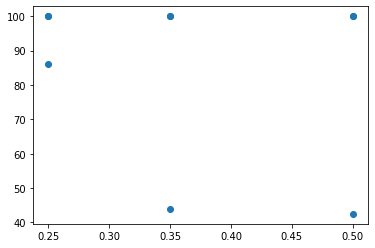

In [70]:
#drops
#learns
#acc
plt.scatter(drops, acc)

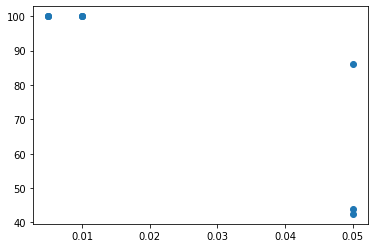

In [71]:
plt.scatter(learns, acc)

In [72]:
drops = []
learns = []
acc = []

for i,dropout in enumerate(dropout_search):
    for j, learning in enumerate(learning_search):
        if learning <= 0.01:
            drops.append(dropout)
            learns.append(learning)
            acc.append(full_acc_per_fold2[i][j])

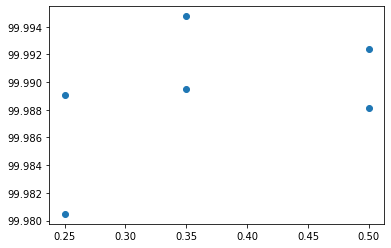

In [73]:
plt.scatter(drops, acc)

In [ ]:
Ablation Study

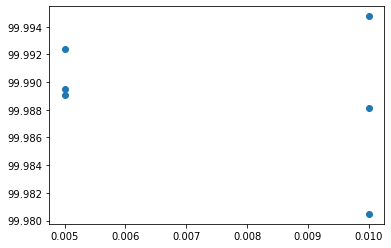

In [74]:
plt.scatter(learns, acc)

A learning rate of 0.01 and a dropout of .35 appears to be the most performant, this function probably can be used to refactor the above with different parameters, but for quick coding, it's just a copy with new parameter of `pat` which is the patience of our Neural Network's Early stopping. Upping this value will allow us to keep trying for better

In [43]:
def kfolds_bidir_weights_model(n,dropout,learning,n_epochs,pat ):
    # K-fold Cross Validation model evaluation
    fold_no = 1
    acc_per_fold =[]
    loss_per_fold=[]
    preds_per_fold = []
    y_test_per_fold = []
    models =[]
    histories=[]
    #classificat_reports=[]
    
    safety = EarlyStopping(monitor='val_loss', patience=pat, restore_best_weights=True)
    
    inv_map = {v: k for k, v in tag_map.items()}
    label_class_weight = {}
    for i in range(len(word_map)):
        if i < 8:
            if inv_map[i]=='O' or inv_map[i]==0: # freuqent class of 'O' or '0'
                label_class_weight[i] = 1.0
            else:
                label_class_weight[i] = 2000.0 # tags we actually care about (ratio for # of 0 tags to true labels)
        else: 
            label_class_weight[i] = 1.0

    kf = KFold(n_splits = n)
    for train, test in kf.split(X, y):

      # Define the model architecture
        model1 = Sequential()
        model1.add(Embedding(len(word_map), 300, input_length=max_len))
        model1.add(Bidirectional(LSTM(256, return_sequences=True)))
        model1.add(Dropout(dropout)) #play with this value 
        model1.add(TimeDistributed(Dense(len(tag_map),activation='softmax')))

        opt =Adam(learning_rate=learning)
        
      # Compile the model
        #change the learning rate
        model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


      # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

      # Fit data to model
        history = model1.fit(X[train], y[train], epochs=n_epochs, validation_data=(X[test], y[test]), batch_size=20, 
                             callbacks = [safety], class_weight = label_class_weight) #add weights param
        histories.append(history)
      # Generate generalization metrics
        scores = model1.evaluate(X[test], y[test], verbose=0)
        
        preds = model1.predict(X[test])
        preds_per_fold.append(preds)
        y_test = y[test]
        y_test_per_fold.append(y_test)
        print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        models.append(model1)

      # Increase fold number
        fold_no = fold_no + 1
    return (acc_per_fold, loss_per_fold,preds_per_fold,y_test_per_fold,models)

In [44]:
y_test_per_fold.append(y_test)
preds_per_fold.append(preds)

# Final Run of LSTM with Weights and Higher Patience

In [45]:
k=5
results = kfolds_bidir_weights_model(k,.35,0.01,100, 5) #100 epochs, 5 stop tolerance
k_avg_acc_per_fold=sum(results[0])/k
k_avg_loss_per_fold=sum(results[1])/k
k_preds=results[2]
k_y_test =results[3]
k_models = results[4]

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
6/6 [==============================] - 14s 2s/step - loss: 2.3348 - accuracy: 0.4532 - val_loss: 0.0999 - val_accuracy: 0.9931
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 0.1289 - accuracy: 0.9868 - val_loss: 0.0514 - val_accuracy: 0.9940
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 0.0523 - accuracy: 0.9940 - val_loss: 0.0419 - val_accuracy: 0.9940
Epoch 4/100
6/6 [==============================] - 10s 2s/step - loss: 0.0423 - accuracy: 0.9940 - val_loss: 0.0377 - val_accuracy: 0.9940
Epoch 5/100
6/6 [==============================] - 10s 2s/step - loss: 0.0343 - accuracy: 0.9939 - val_loss: 0.0345 - val_accuracy: 0.9940
Epoch 6/100
6/6 [==============================] - 10s 2s/step - loss: 0.0264 - accuracy: 0.9940 - val_loss: 0.0315 - val_accuracy: 0.9940
Epoch 7/100
6/6 [==============================] - 10s 2s/step - loss

## Saving Final Model Results

In [46]:
#%store results

In [47]:
k_avg_acc_per_fold=sum(results[0])/k
k_avg_loss_per_fold=sum(results[1])/k
k_preds=results[2]
k_y_test =results[3]
k_models = results[4]

In [48]:
# Pickle Model for Usage in other Code
f = open('k_avg_acc_per_fold', 'wb')
pickle.dump(k_avg_acc_per_fold, f)
f.close()
# Pickle Model for Usage in other Code
f = open('k_avg_loss_per_fold', 'wb')
pickle.dump(k_avg_loss_per_fold, f)
f.close()
# Pickle Model for Usage in other Code
f = open('k_preds', 'wb')
pickle.dump(k_preds, f)
f.close()
# Pickle Model for Usage in other Code
f = open('k_y_test', 'wb')
pickle.dump(k_y_test, f)
f.close()

In [49]:
k_models

In [50]:
from keras.models import load_model
for i,model in enumerate(k_models):
    model.save(f'my_model_{i}.h5')  # creates a HDF5 file 'my_model.h5'
    #del model  # deletes the existing model

In [26]:
#https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi
from keras.models import load_model
fname = 'my_model_'+str(1)+'.h5'
model = load_model(fname)

In [28]:
k_avg_acc_per_fold = pickle.load(open('k_avg_acc_per_fold', 'rb'))
k_avg_loss_per_fold = pickle.load(open('k_avg_loss_per_fold', 'rb'))
k_preds = pickle.load(open('k_preds', 'rb'))
k_y_test = pickle.load(open('k_y_test', 'rb'))

In [29]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1000, 300)         4752900   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 1000, 512)         1140736   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000, 512)         0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 1000, 8)           4104      
Total params: 5,897,740
Trainable params: 5,897,740
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.models import load_model
k_models_2=[]
for i in range(5):
    fname = 'my_model_'+str(i)+'.h5'
    model = load_model(fname)
    print(f'Loaded {str(i)}th model')
    k_models_2.append(model)
k_models_2

Loaded 0th model
Loaded 1th model
Loaded 2th model
Loaded 3th model
Loaded 4th model


In [63]:
classification_rep = classification_report(
            k_y_test.ravel(), 
            np.argmax(k_preds,
                      axis=2).ravel(), 
            digits=3#, labels=sorted_labels,
    #labels change everything to 0
                    )
        
print(classification_rep)

                    precision    recall  f1-score   support

B-Defendant lawyer      0.000     0.000     0.000         0
I-Defendant lawyer      0.000     0.000     0.000         0
           B-Judge      0.000     0.000     0.000         0
           I-Judge      0.000     0.000     0.000         0
       B-State Rep      0.000     0.000     0.000         0
       I-State Rep      0.000     0.000     0.000         0

         micro avg      0.000     0.000     0.000         0
         macro avg      0.000     0.000     0.000         0
      weighted avg      0.000     0.000     0.000         0



In [36]:
for i,model in enumerate(k_models_2):
    print('----------------','Model ',i,'----------------')
    print(model)
#    print(dropout,',',learning,',',full_acc_per_fold2[i][j])

---------------- Model  0 ----------------
---------------- Model  1 ----------------
---------------- Model  2 ----------------
---------------- Model  3 ----------------
---------------- Model  4 ----------------


In [34]:

k_models_2[4].history